# Final project: Football transfer network
----

### Problems covered in this document:
- determination of best football academies and clubs which buy young players and then sell them more expensive;
- detection club cooperations (clubs which often give players a loan to the same club).

### Description of the network
[<span style="color:red">to do</span>]

#### Nodes 
[<span style="color:red">to do</span>]

#### Edges
[<span style="color:red">to do</span>]

-------
## Imports

In [1]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import groupby 
import networkx.readwrite.json_graph as json_graph
import community as community 

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Reading networks and creating combined networks

Names of networks are correspond with name of files with data:


All networks read as MultiGraph.

In [3]:
all_transfers = nx.read_gml('networks/all_transfers_network.gml')
free_transfers = nx.read_gml('networks/transfers_free_network.gml')
loans = nx.read_gml('networks/transfers_loan_network.gml')
swap_transfers = nx.read_gml('networks/transfers_swap_network.gml')
transfers = nx.read_gml('networks/transfers_transfer_network.gml')

In [4]:
#clubs in-/out-degree for loans
loans_indegree = loans.in_degree()
loans_outdegree = loans.out_degree()
#clubs in-/out-degree for transfers
transfers_indegree = transfers.in_degree()
transfers_outdegree = transfers.out_degree()

In [5]:
def print_top10(mydict, g):
    sort = sorted([(value,key) for (key,value) in mydict.items()])
    sort.reverse()
    for (score,node) in sort[:10]:
        print(node, '--',g.node[node]['competition'], '---', round(score,5))

---
## Transfers distribution by age

In [6]:
ages_dict_loans = {}

#there are several links between nodes
#first node
for u in loans.nodes():    
    #second node
    for v in loans.nodes():
    #determine number of links between clubs u and v
        try:
            link_number = len(loans[u][v])
        except:
            link_number = 0
        if link_number > 0:
            for i in range(0, link_number, 1):
                age=round(float(loans[u][v][i]['playerAge']),0)
                try:
                    ages_dict_loans[age] += 1
                except:
                    ages_dict_loans[age] = 1
                

In [7]:
ages_dict_transfers = {}
age_price_transfers = {}
#there are several links between nodes
#first node
for u in transfers.nodes():  
    #second node
    for v in transfers.nodes():
    #determine number of links between clubs u and v
        try:
            link_number = len(transfers[u][v])
        except:
            link_number = 0
        if link_number > 0:
            for i in range(0, link_number, 1):
                age=round(float(transfers[u][v][i]['playerAge']),0)
                price=round(float(transfers[u][v][i]['transferValue']),0)
                try:
                    ages_dict_transfers[age] += 1
                except:
                    ages_dict_transfers[age] = 1
                try:
                    age_price_transfers[age] += price
                except:
                    age_price_transfers[age] = price

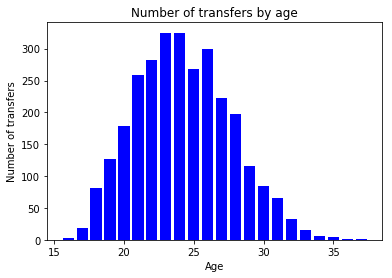

In [8]:
plt.bar(list(ages_dict_transfers.keys()), ages_dict_transfers.values(), color='b')
plt.xlabel('Age')
plt.ylabel('Number of transfers')
plt.title("Number of transfers by age")
plt.show()

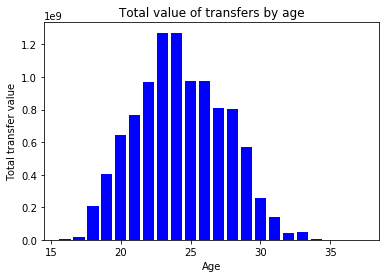

In [9]:
plt.bar(list(age_price_transfers.keys()), age_price_transfers.values(), color='b')
plt.xlabel('Age')
plt.ylabel('Total transfer value')
plt.title("Total value of transfers by age")
plt.show()

In [10]:
#calculating average transfer value
age_price_transfers_average = {}
for age in age_price_transfers.keys():
    #average value of age = total value of age / number of transfers of age
    age_price_transfers_average[age] = age_price_transfers[age]/ages_dict_transfers[age]

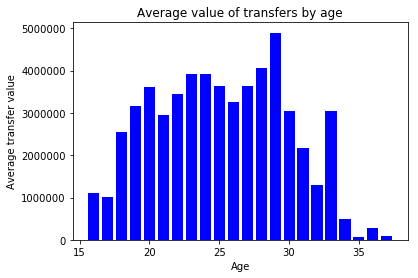

In [11]:
plt.bar(list(age_price_transfers_average.keys()), age_price_transfers_average.values(), color='b')
plt.xlabel('Age')
plt.ylabel('Average transfer value')
plt.title("Average value of transfers by age")
plt.show()

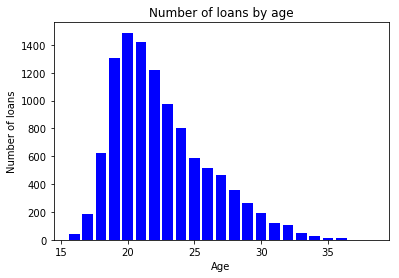

In [12]:
plt.bar(list(ages_dict_loans.keys()), ages_dict_loans.values(), color='b')
plt.xlabel('Age')
plt.ylabel('Number of loans')
plt.title("Number of loans by age")
plt.show()

Distribution of transfers by age is a normal distribution with mean 23-24 years. Distribution of loans by age is is biased relative to the transfer's distribution in the direction of younger age. The reason is that young players usually loaned by their home club and sold only in more mature age because price for experienced players is higher. On the graph with average transfer value we can find that after 17 transfer value of players more than twice higher that before 17. Also, it is gradually growing and this is one of the most important reason for loaning young players and sell them only in mature age. 
Total value of transfers by age is normally distributed, because average transfer value of players between 20 and 30 is almost equal but number of transfers is normally distributed.

---
## Determination of best football academies

For determination of best academies we decided to calculate number of transfers and loans of a players of a different age groups: under 21, between 22 and 24, between 25 and 29, and after 30. Then, find clubs with high value of transfers of young palyers we can determine these types of clubs.

Also, by this information we can find clubs which make business on players reselling. They should have high value of in-transfers of young player, out-loans, and out-transfer but second age group (22-24 years).

In [13]:
#creating dictionaries with number of loans and transfer per club
#every dict cover one of three age groups: under 21, 22-24, 25-29, after 30
in_loans_under21 = {}
in_loans_22_24 = {}
in_loans_25_29 = {}
in_loans_after30 = {}

out_loans_under21 = {}
out_loans_22_24 = {}
out_loans_25_29 = {}
out_loans_after30 = {}

total_in_under21 = {}
total_in_22_24 = {}
total_in_25_29 = {}
total_in_after30 = {}
total_out_under21 = {}
total_out_22_24 = {}
total_out_25_29 = {}
total_out_after30 = {}

#creating dicts for loans
#taking node u
for u in loans.nodes():
    #taking node v
    for v in loans.nodes():
    #determine number of links between clubs u and v
        try:
            link_number = len(loans[u][v])
        except:
            link_number = 0
        #if number of transfer not 0 make a loop
        if link_number > 0:
            for i in range(0, link_number, 1):
                age = float(loans[u][v][i]['playerAge'])
                if age <= 21:
                    try:
                        in_loans_under21[v] += 1
                        out_loans_under21[u] += 1
                    except:
                        in_loans_under21[v] = 1
                        out_loans_under21[u] = 1

                if (age > 21) and (age <= 24):
                    try:
                        in_loans_22_24[v] += 1
                        out_loans_22_24[u] += 1
                    except:
                        in_loans_22_24[v] = 1
                        out_loans_22_24[u] = 1
                        
                if (age > 24) and (age <= 30):
                    try:
                        in_loans_25_29[v] += 1
                        out_loans_25_29[u] += 1
                    except:
                        in_loans_25_29[v] = 1
                        out_loans_25_29[u] = 1

                if age > 30:
                    try:
                        in_loans_after30[v] += 1
                        out_loans_after30[u] += 1
                    except:
                        in_loans_after30[v] = 1
                        out_loans_after30[u] = 1

In [14]:
in_transfers_under21 = {}
in_transfers_22_24 = {}
in_transfers_25_29 = {}
in_transfers_after30 = {}
out_transfers_under21 = {}
out_transfers_22_24 = {}
out_transfers_25_29 = {}
out_transfers_after30 = {}

#creating dicts for transfers      
for u in transfers.nodes():    
    for v in transfers.nodes():
    #determine number of links between clubs u and v
        try:
            link_number = len(transfers[u][v])
        except:
            link_number = 0
        if link_number > 0:
            for i in range(0, link_number, 1):
                age=float(transfers[u][v][i]['playerAge'])
                if age <= 21:
                    try:
                        in_transfers_under21[v] += 1
                        out_transfers_under21[u] += 1
                    except:
                        in_transfers_under21[v] = 1
                        out_transfers_under21[u] = 1

                if (age > 21) and (age <= 24):
                    try:
                        in_transfers_22_24[v] += 1
                        out_transfers_22_24[u] += 1
                    except:
                        in_transfers_22_24[v] = 1
                        out_transfers_22_24[u] = 1                        
                        
                if (age > 24) and (age <= 30):
                    try:
                        in_transfers_25_29[v] += 1
                        out_transfers_25_29[u] += 1
                    except:
                        in_transfers_25_29[v] = 1
                        out_transfers_25_29[u] = 1

                if age > 30:
                    try:
                        in_transfers_after30[v] += 1
                        out_transfers_after30[u] += 1
                    except:
                        in_transfers_after30[v] = 1
                        out_transfers_after30[u] = 1

In [15]:
#fuctions for sorting dict from max to min
def sort_dict(d):
    d = [(k, d[k]) for k in sorted(d, key=d.get, reverse=True)]
    return d

In [16]:
#creat combined dicts with out loans and transfers for each club for each age group
total_out_under21 = {k: out_loans_under21.get(k, 0) + out_transfers_under21.get(k, 0) for k in set(out_loans_under21) | set(out_transfers_under21)}
total_out_22_24 = {k: out_loans_22_24.get(k, 0) + out_transfers_22_24.get(k, 0) for k in set(out_loans_22_24) | set(out_transfers_22_24)}
total_out_25_29 = {k: out_loans_25_29.get(k, 0) + out_transfers_25_29.get(k, 0) for k in set(out_loans_25_29) | set(out_transfers_25_29)}
total_out_after30 = {k: out_loans_after30.get(k, 0) + out_transfers_after30.get(k, 0) for k in set(out_loans_after30) | set(out_transfers_after30)}

In [17]:
#creat combined dicts with in loans and transfers for each club for each age group
total_in_under21 = {k: in_loans_under21.get(k, 0) + in_transfers_under21.get(k, 0) for k in set(in_loans_under21) | set(in_transfers_under21)}
total_in_22_24 = {k: in_loans_22_24.get(k, 0) + in_transfers_22_24.get(k, 0) for k in set(in_loans_22_24) | set(in_transfers_22_24)}
total_in_25_29 = {k: in_loans_25_29.get(k, 0) + in_transfers_25_29.get(k, 0) for k in set(in_loans_25_29) | set(in_transfers_25_29)}
total_in_after30 = {k: in_loans_after30.get(k, 0) + in_transfers_after30.get(k, 0) for k in set(in_loans_after30) | set(in_transfers_after30)}

In [18]:
def rate(out_loan, in_transfer):
    rate ={}
    for club in out_loan.keys():
        try:
            rate[club] = out_loan[club]/in_transfer[club]
        except:
            rate[club] = out_loan[club]
    return rate

In [19]:
print('\033[1m' + 'LOANS AT THE CLUB LEVEL' + '\033[0m')
print('----- Top-10 clubs with high value of in loans under 21 years -----')
print_top10(in_loans_under21, loans)
print('\n')
print('----- Top-10 clubs with high value of out loans under 21 years -----')
print_top10(out_loans_under21, loans)
print('\n')
print('----- Top-10 clubs with high value of in loans between 22 and 24 years -----')
print_top10(in_loans_22_24, loans)
print('\n')
print('----- Top-10 clubs with high value of out loans between 22 and 24 years -----')
print_top10(out_loans_22_24, loans)
print('\n')
print('----- Top-10 clubs with high value of in loans between 25 and 29 years -----')
print_top10(in_loans_25_29, loans)
print('\n')
print('----- Top-10 clubs with high value of out loans between 25 and 29 years -----')
print_top10(out_loans_25_29, loans)
print('\n')
print('----- Top-10 clubs with high value of in loans after 30 -----')
print_top10(in_loans_after30, loans)
print('\n')
print('----- Top-10 clubs with high value of out loans after 30 -----')
print_top10(out_loans_after30, loans)
print('\n')

LOANS AT THE CLUB LEVEL
----- Top-10 clubs with high value of in loans under 21 years -----
Paganese -- Prima Divisione - Girone C --- 17
Siena -- Prima Divisione - B --- 15
Pontedera -- Prima Divisione - B --- 15
SPAL -- Prima Divisione - B --- 12
Olbia -- Serie D - Girone G --- 12
Latina Calcio -- Serie B --- 11
Como -- Serie B --- 11
Ascoli -- Prima Divisione - B --- 11
Piacenza -- Serie D - Girone B --- 10
Mantova FC -- Prima Divisione - A --- 10


----- Top-10 clubs with high value of out loans under 21 years -----
Lazio -- Serie A --- 22
Udinese Calcio -- Serie A --- 18
Fiorentina -- Serie A --- 17
Entella U19 -- Campionato Primavera Girone A --- 16
Chelsea U23 -- U21 Premier League --- 13
Ascoli U19 -- Campionato Primavera Girone C --- 12
Tottenham U21 -- U21 Premier League --- 11
Novara -- Prima Divisione - A --- 11
Hellas Verona -- Serie A --- 11
Spezia Calcio -- Serie B --- 10


----- Top-10 clubs with high value of in loans between 22 and 24 years -----
Carpi -- Serie B --- 

In [20]:
print('\033[1m' + 'TRANSFERS AT THE CLUB LEVEL' + '\033[0m')
print('----- Top-10 clubs with high value of in transfers under 21 years -----')
print_top10(in_transfers_under21, transfers)
print('\n')
print('----- Top-10 clubs with high value of out transfers under 21 years -----')
print_top10(out_transfers_under21, transfers)
print('\n')
print('----- Top-10 clubs with high value of in transfers between 22 and 24 years -----')
print_top10(in_transfers_22_24, transfers)
print('\n')
print('----- Top-10 clubs with high value of out transfers between 22 and 24 years -----')
print_top10(out_transfers_22_24, transfers)
print('\n')
print('----- Top-10 clubs with high value of in transfers between 25 and 29 years -----')
print_top10(in_transfers_25_29, transfers)
print('\n')
print('----- Top-10 clubs with high value of out transfers between 25 and 29 years -----')
print_top10(out_transfers_25_29, transfers)
print('\n')
print('----- Top-10 clubs with high value of in transfers after 30 -----')
print_top10(in_transfers_after30, transfers)
print('\n')
print('----- Top-10 clubs with high value of out transfers after 30 -----')
print_top10(out_transfers_after30, transfers)
print('\n')

TRANSFERS AT THE CLUB LEVEL
----- Top-10 clubs with high value of in transfers under 21 years -----
VfB Stuttgart -- 1.Bundesliga --- 3
G. Bordeaux -- Ligue 1 --- 3
Everton -- Premier League --- 3
Trabzonspor -- Süper Lig --- 2
Sevilla Atl. -- Segunda División B - Grupo IV --- 2
Sampdoria U19 -- Campionato Primavera Girone A --- 2
RM Castilla -- Segunda División B - Grupo II --- 2
RB Salzburg -- Bundesliga --- 2
Olympique Lyon -- Ligue 1 --- 2
OGC Nice -- Ligue 1 --- 2


----- Top-10 clubs with high value of out transfers under 21 years -----
OFK Beograd -- SuperLiga --- 3
LOSC Lille -- Ligue 1 --- 3
FC Schalke 04 -- 1.Bundesliga --- 3
Empoli U19 -- Campionato Primavera Girone C --- 3
AS Trencin -- Corgon liga --- 3
Valenciennes FC -- Ligue 2 --- 2
Troyes -- Ligue 2 --- 2
São Paulo -- Campeonato Brasileiro Série A --- 2
Spezia Calcio -- Serie B --- 2
Sheffield Utd. -- League One --- 2


----- Top-10 clubs with high value of in transfers between 22 and 24 years -----
SC Freiburg -- 1.Bu

In [21]:
#fuction for calculating number of loans or transfer in one of the age group by leagues
def age_group_league(my_dict, g):
    #dictionary with results
    g_league = {}
    #loop through the dictionary
    for club in my_dict.keys():
        #determination of league of the club
        league = g.node[club]['competition']
        try:
            g_league[league] += 1
        except:
            g_league[league] = 1
    return g_league

In [22]:
def print_top10_leagues(mydict):
    sort = sorted([(value,key) for (key,value) in mydict.items()])
    sort.reverse()
    for (score,node) in sort[:10]:
        print(node, '---', round(score,5))

In [23]:
print('\033[1m' + 'LOANS AT THE LEAGUE LEVEL' + '\033[0m')
print('----- Top-10 leagues with high value of in loans under 21 years -----')
print_top10_leagues(age_group_league(in_loans_under21, loans))
print('\n')
print('----- Top-10 leagues with high value of out loans under 21 years -----')
print_top10_leagues(age_group_league(out_loans_under21, loans))
print('\n')
print('----- Top-10 leagues with high value of in loans between 22 and 24 years -----')
print_top10_leagues(age_group_league(in_loans_22_24, loans))
print('\n')
print('----- Top-10 leagues with high value of out loans between 22 and 24 years -----')
print_top10_leagues(age_group_league(out_loans_22_24, loans))
print('\n')
print('----- Top-10 leagues with high value of in loans between 25 and 29 years -----')
print_top10_leagues(age_group_league(in_loans_25_29, loans))
print('\n')
print('----- Top-10 leagues with high value of out loans between 25 and 29 years -----')
print_top10_leagues(age_group_league(out_loans_25_29, loans))
print('\n')
print('----- Top-10 leagues with high value of in loans after 30 -----')
print_top10_leagues(age_group_league(in_loans_after30, loans))
print('\n')
print('----- Top-10 leagues with high value of out loans after 30 -----')
print_top10_leagues(age_group_league(out_loans_after30, loans))
print('\n')

LOANS AT THE LEAGUE LEVEL
----- Top-10 leagues with high value of in loans under 21 years -----
Primera División --- 31
Conference National --- 25
League One --- 24
Prima Divisione - B --- 23
Serie B --- 22
Serie D - Girone C --- 21
Prima Divisione - Girone C --- 21
League Two --- 21
USL Pro --- 19
Serie D - Girone E --- 19


----- Top-10 leagues with high value of out loans under 21 years -----
U21 Premier League --- 30
Premier League --- 24
Serie B --- 23
Championship --- 23
Serie A --- 20
Primera División --- 20
League One --- 19
Prima Divisione - A --- 18
Ligue 1 --- 18
Prima Divisione - B --- 17


----- Top-10 leagues with high value of in loans between 22 and 24 years -----
Primera División --- 41
USL Pro --- 27
League Two --- 24
League One --- 24
Serie B --- 23
Prima Divisione - Girone C --- 23
Premier Liga --- 23
Championship --- 23
Segunda Liga --- 22
Campeonato Brasileiro Série B --- 22


----- Top-10 leagues with high value of out loans between 22 and 24 years -----
Primera 

In [24]:
print('\033[1m' + 'TRANSFERS AT THE LEAGUE LEVEL' + '\033[0m')
print('----- Top-10 leagues with high value of in transfers under 21 years -----')
print_top10_leagues(age_group_league(in_transfers_under21, transfers))
print('\n')
print('----- Top-10 leagues with high value of out transfers under 21 years -----')
print_top10_leagues(age_group_league(out_transfers_under21, transfers))
print('\n')
print('----- Top-10 leagues with high value of in transfers between 22 and 24 years -----')
print_top10_leagues(age_group_league(in_transfers_22_24, transfers))
print('\n')
print('----- Top-10 leagues with high value of out transfers between 22 and 24 years -----')
print_top10_leagues(age_group_league(out_transfers_22_24, transfers))
print('\n')
print('----- Top-10 leagues with high value of in transfers between 25 and 29 years -----')
print_top10_leagues(age_group_league(in_transfers_25_29, transfers))
print('\n')
print('----- Top-10 leagues with high value of out transfers between 25 and 29 years -----')
print_top10_leagues(age_group_league(out_transfers_25_29, transfers))
print('\n')
print('----- Top-10 leagues with high value of in transfers after 30 -----')
print_top10_leagues(age_group_league(in_transfers_after30, transfers))
print('\n')
print('----- Top-10 leagues with high value of out transfers after 30 -----')
print_top10_leagues(age_group_league(out_transfers_after30, transfers))
print('\n')

TRANSFERS AT THE LEAGUE LEVEL
----- Top-10 leagues with high value of in transfers under 21 years -----
1.Bundesliga --- 18
Serie A --- 16
Premier League --- 15
Primera División --- 11
Ligue 1 --- 10
Championship --- 10
Süper Lig --- 8
2.Bundesliga --- 8
Eredivisie --- 7
League One --- 6


----- Top-10 leagues with high value of out transfers under 21 years -----
Primera División --- 12
Ligue 1 --- 12
1.Bundesliga --- 11
Serie A --- 10
Serie B --- 8
Premier League --- 8
Ligue 2 --- 8
Championship --- 8
Campeonato Brasileiro Série A --- 8
SuperLiga --- 7


----- Top-10 leagues with high value of in transfers between 22 and 24 years -----
Primera División --- 24
Championship --- 20
Serie A --- 19
Premier League --- 19
1.Bundesliga --- 18
Ligue 1 --- 15
2.Bundesliga --- 14
Serie B --- 13
Chinese Super League --- 13
Liga MX Clausura --- 12


----- Top-10 leagues with high value of out transfers between 22 and 24 years -----
Primera División --- 29
1.Bundesliga --- 18
Premier League --- 17


Using data above we can't say anything about football academies or business of growing players and reselling them because we have data only for 2 years (4 transfer windows). It is not enough for analysing these ideas because process of growing players takes at least 2-3 years.

But using this data we can find clubs and leagues which usually buy/loan players of specific age group. 

__Loans and transfers at the club level__

In the list of transfers of young players we can't find top clubs because they usually have academies and give chances for their players. Most of clubs in these lists represents lower leagues.

In the list of clubs selling players of 22-24 years I can highlite clubs which took high places in the championships but not very rich (Marseille, RB Salzburg, Monaco, Benfica). After achieving good results, the demand for their players has increased dramatically. 

In the lists of transfers of 25-29 years players are clubs from China, lower leagues (Championship, Segunda, 2nd Bundesliga) and non-top clubs (Newcastle, Torino). Probably Juventus is unexpected in this list, but this club know for buying age-old but upscale football players (Dani Alves, Khedira, Higuain).

In the lists of transfers of older than 30 years players we can't find clubs that bought or sold more than 2 players. But most of these clubs represent not top clubs. 

Most of clubs which take players for a loan at the age under 24 represent lower leagues, clubs that give palyers for a loan are junior teams or also clubs from lower leagues. Same trends we can find for players after 24 years, except junior team because they have no age-old players.


__Loans and transfers at the league level__

__ДОБАВИТЬ ПРО АРЕНДУ__


Main buyers and seller of players of all age are top-5 leagues - 1st leagues of Germany, Italy, England, Spain, France. But main leagues for loans are lower divisions and La Liga (I think because of regalations allowing loan and buy players from South America, while in England it's not allowed).